# Capstone Project - The Battle of Neighborhoods

### Introduction

In this project I have explored different venues in the New York city.  With almost 20 million people in its metropolitan statistical area and approximately 23 million in its combined statistical area, it is one of the world's most populous megacities.  New York City has been described as the cultural, financial, and media capital of the world, significantly influencing commerce, entertainment, research, technology, education, politics, tourism, art, fashion, and sports. 

As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. New York is home to more than 3.2 million residents born outside the United States, the largest foreign-born population of any city in the world as of 2016.

With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , Italian etc.

So as part of this project , we will list and visualize all major parts of New York City that has great Indian resturants.

Also we would try to find answers to the following questions-

- What is best location in New York City for Indian Cuisine ? 
- Which areas have potential Indian Resturant Market ? 
- Which all areas lack Indian Resturants ?
- Which is the best place to stay if I prefer Indian Cuisine ?

### Data 
For this project we need the following data :
<ul>
<li> New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
    <ul>
        <li>Data source : https://cocl.us/new_york_dataset
        <li> Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.
     </ul>
<li> Indian resturants in each neighborhood of new york city.
        <ul>
        <li>Data source : Fousquare API
        <li> Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only indian resturants.
     </ul>
<li> GeoSpace data
          <ul>
        <li>Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
        <li> Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.
  
</ul>

### Approach
- Collect the new york city data from https://cocl.us/new_york_dataset
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are Japanese Resturants.
- Find rating , tips and like count for each Japanese Resturants using FourSquare API.
- Using rating for each resturant , we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)

### Analysis

We will import the required libraries for python.

- pandas and numpy for handling data.
- request module for using FourSquare API.
- geopy to get co-ordinates of City of New York.
- folium to visualize the results on a map

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
import os
import folium # map rendering library
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Pradhan\Anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0




geographiclib-1.50   | 34 KB     |            |   0% 
geographiclib-1.50   | 34 KB     | ####7      |  47% 
geographiclib-1.50   | 34 KB     | ########## | 100% 

geopy-1.22.0         | 63 KB     |            |   0% 
geopy-1.22.0     

Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given  latitude and longitude. Below function will return us the venue id , venue name and category.

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100


    CLIENT_ID = '3LTW3SAN11MPJMVNE21H0R0UNO5MQNBGXVBNKFBE0MDL4DRN' # your Foursquare ID
    CLIENT_SECRET = 'AMOTYOUPWE4XUSUPFGFSZOYMP5TTA5DHHUOPGZDZ1IHWAY5I' # your Foursquare Secret

    VERSION = '20180604'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df
    

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id.
This will be used for ranking.

In [36]:
def get_venue_details(venue_id):
        


    CLIENT_ID = 'R01LINGO2WC45KLRLKT3ZHU2QENAO2IPRK2N2ELOHRNK4P3K' # your Foursquare ID
    CLIENT_SECRET = '4JT1TWRMXMPLX5IOKNBAFU3L3ARXK4D5JJDPFK1CLRZM2ZVW' # your Foursquare Secret

    VERSION = '20180604'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [6]:
# get new york data
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

So there are total of 306 different Neighborhoods in New York

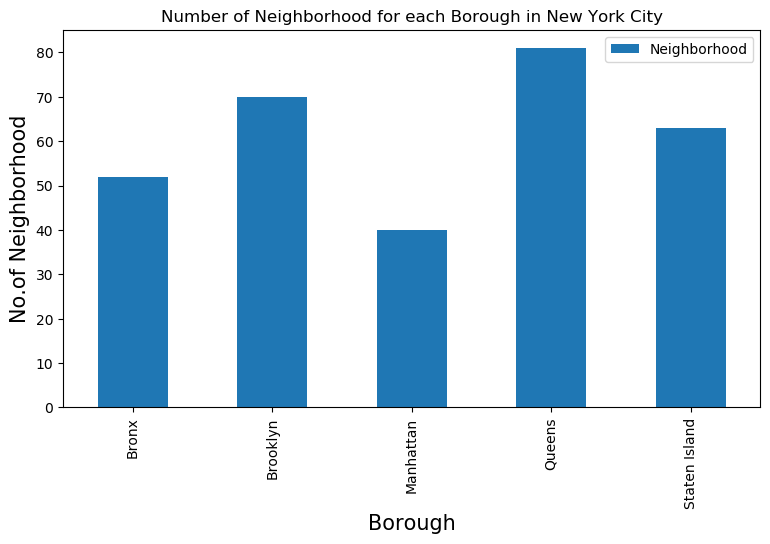

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Indian resturants for each Neighborhood

In [13]:
# prepare neighborhood list that contains japanese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1


( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Indian Resturants in Ozone Park, Queens:0
( 149 / 306 ) Indian Resturants in South Ozone Park, Queens:1
( 150 / 306 ) Indian Resturants in College Point, Queens:0
( 151 / 306 ) Indian Resturants in Whitestone, Queens:0
( 152 / 306 ) Indian Resturants in Bayside, Queens:3
( 153 / 306 ) Indian Resturants in Auburndale, Queens:0
( 154 / 306 ) Indian Resturants in Little Neck, Queens:0
( 155 / 306 ) Indian Resturants in Douglaston, Queens:0
( 156 / 306 ) Indian Resturants in Glen Oaks, Queens:4
( 157 / 306 ) Indian Resturants in Bellerose, Queens:0
( 158 / 306 ) Indian Resturants in Kew Gardens Hills, Queens:1
( 159 / 306 ) Indian Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Indian Resturants in Briarw

( 280 / 306 ) Indian Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Indian Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Indian Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Resturants in Roxbury, Queens:0
( 290 / 306 ) Indian Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Resturants in Middle Village, Queens:0
( 292 / 306 ) Indian Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Indian Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Indian Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Indian Resturants in Malba, Queens:0
( 296 / 306 ) Indian Re

Now that we have got all the indian resturants in new york city , we will analyze it

In [14]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [15]:
indian_rest_ny.shape

(147, 4)

We got !47 Indian Resturants across New York City

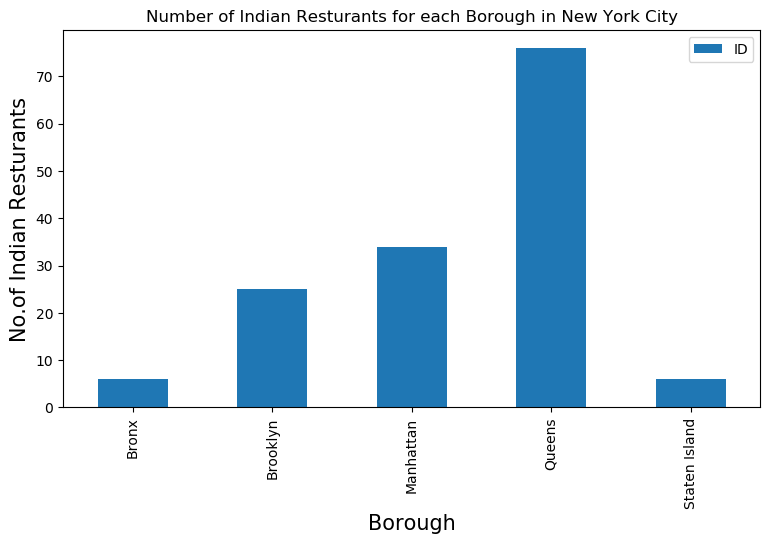

In [17]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has the largest number of indian resturants

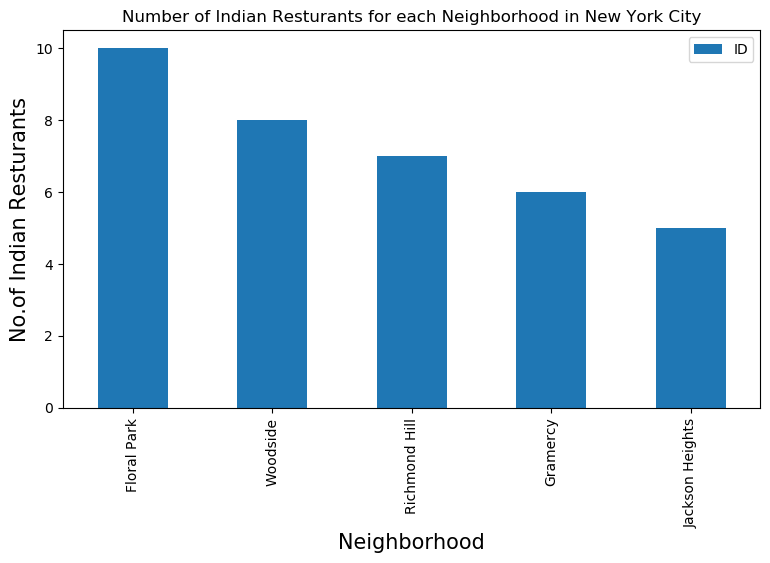

In [20]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [22]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
102,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
103,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
104,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
105,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
106,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
107,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
108,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
109,Queens,Floral Park,55d68c1b498ecf05fa196fe1,Namaste Restaurant and Cafe
110,Queens,Floral Park,4ec1b54f4690d2338a359d66,Tabaq Kebab Grill
111,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


So Floral Park in Queens has the highest number of Indian Resturants with a total count of 7.

Now we will get the ranking of each resturant for further analysis.

In [37]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1


                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.8    10
( 1 / 147 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 2 / 147 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.0     9
( 3 / 147 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.8     3
( 4 / 147 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 5 / 147 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     38     8.0    26
( 6 / 147 ) processed
                         ID          Name  Likes

                         ID            Name  Likes  Rating  Tips
0  4afdcf29f964a520162b22e3  Rajbhog Sweets     37     8.5    25
( 54 / 147 ) processed
                         ID      Name  Likes  Rating  Tips
0  4c7060e734443704ca0e245f  Kababish     30     7.8    18
( 55 / 147 ) processed
                         ID                      Name  Likes  Rating  Tips
0  4b998d3ff964a520fc8235e3  Maharaja Sweets & Snacks     52     8.3    25
( 56 / 147 ) processed
                         ID  Name  Likes  Rating  Tips
0  4b189424f964a52043d423e3  Dera     48     7.7    19
( 57 / 147 ) processed
                         ID                     Name  Likes  Rating  Tips
0  5da4fbf091a08400078be19d  Angel Indian Restaurant     11     8.0     1
( 58 / 147 ) processed
                         ID           Name  Likes  Rating  Tips
0  49ebb18ff964a52016671fe3  Delhi Heights     34     7.8    24
( 59 / 147 ) processed
                         ID                         Name  Likes  Rating  Tips


                         ID           Name  Likes  Rating  Tips
0  4c0c01e0bbc676b00d6b4cd5  Mumbai Xpress     16     6.8    18
( 107 / 147 ) processed
                         ID             Name  Likes  Rating  Tips
0  4c76ff35a5676dcb72671721  Flavor Of India      6     5.9     6
( 108 / 147 ) processed
                         ID           Name  Likes  Rating  Tips
0  4df0f39dd4c04d0392c853ea  Sagar Chinese      7     5.9     6
( 109 / 147 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 55d68c1b498ecf05fa196fe1
( 110 / 147 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4ec1b54f4690d2338a359d66
( 111 / 147 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e6bfe1c7d8b2c711b17bbe5
( 112 / 147 ) processed
                         ID                        Name  Likes  Rating  Tips
0  4f580c1be4b0bdfd0e7e8102  Rajdhani

In [38]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.8,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.0,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.8,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [39]:
indian_rest_stats_ny.shape

(147, 7)

In [40]:
indian_rest_ny.shape

(147, 4)

In [43]:
# Taken a backup in a different dataframe
indian_rest_stats_ny_backup = indian_rest_stats_ny

In [41]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [44]:
indian_rest_stats_ny_backup.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.8,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.0,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.8,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [45]:
indian_rest_stats_ny_backup.shape

(147, 7)

In [46]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [47]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 7 columns):
Borough         147 non-null object
Neighborhood    147 non-null object
ID              147 non-null object
Name            147 non-null object
Likes           147 non-null float64
Rating          147 non-null float64
Tips            147 non-null float64
dtypes: float64(3), object(4)
memory usage: 8.2+ KB


Now the data types looks correct

In [48]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               8.6
Tips                                 148
Name: 40, dtype: object

In [50]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                           Queens
Neighborhood                     Astoria
ID              4aa56c81f964a5204e4820e3
Name                 Seva Indian Cuisine
Likes                                239
Rating                                 9
Tips                                 133
Name: 52, dtype: object

In [51]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a12eb1ff964a52099771fe3
Name                               Dhaba
Likes                                497
Rating                               8.3
Tips                                 164
Name: 48, dtype: object

Lets analyse average rating of the neighborhood

In [53]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [54]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,Neighborhood,Average Rating
0,Astoria,9.000000
4,Blissville,9.000000
64,Sunnyside,9.000000
12,Clinton Hill,8.800000
24,Fort Greene,8.800000
52,Prospect Lefferts Gardens,8.700000
74,West Village,8.700000
51,Prospect Heights,8.700000
69,Tudor City,8.600000
68,Tribeca,8.600000


In [55]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [56]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.158824
1,Brooklyn,7.464000
0,Bronx,6.566667
3,Queens,6.405263
4,Staten Island,5.333333


Similarly these are the average rating of Indian Resturants for each Borough

Lets visualize it

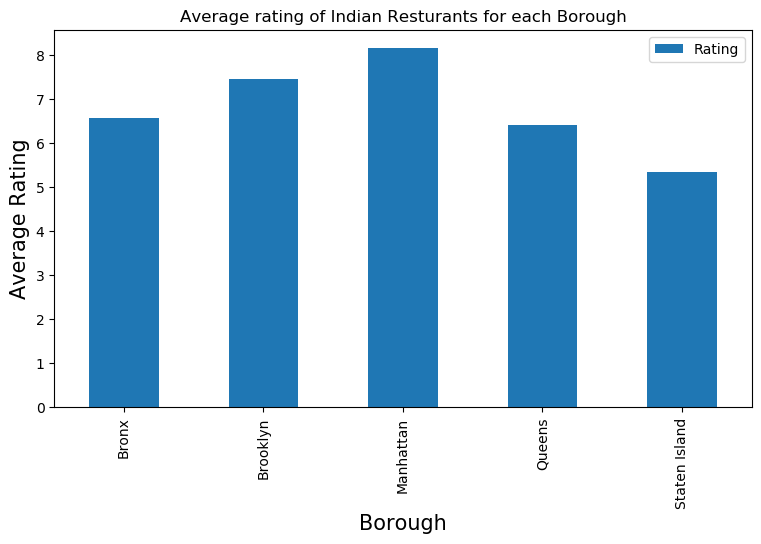

In [58]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map

In [59]:
ny_neighborhood_stats_9=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9]

In [60]:
ny_neighborhood_stats_9

,Neighborhood,Average Rating
0,Astoria,9.0
4,Blissville,9.0
64,Sunnyside,9.0


We will join this dataset to original new york data to get lonitude and latitude

In [61]:
ny_neighborhood_stats_9=pd.merge(ny_neighborhood_stats_9,new_york_data, on='Neighborhood')

In [62]:
ny_neighborhood_stats_9=ny_neighborhood_stats_9[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [63]:
ny_neighborhood_stats_9

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,9.0
1,Queens,Blissville,40.737251,-73.932442,9.0
2,Queens,Sunnyside,40.740176,-73.926916,9.0
3,Staten Island,Sunnyside,40.612760,-74.097126,9.0


Now we will show this data on a map

In [64]:
# create map
map_clusters = folium.Map(geo_location('New York'), zoom_start=12)



# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_neighborhood_stats_9['Latitude'], ny_neighborhood_stats_9['Longitude'], ny_neighborhood_stats_9['Neighborhood'], ny_neighborhood_stats_9['Neighborhood']):
    label = folium.Popup(str(poi) + ' Neighborhood ' + str(Neighborhood), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Lets add a new field to dataframe for labeling purpose

### Conclusion 
- Astoria(Queens), Blissville(Queens), Sunnyside(Queens) are some of the best neighborhoods for Indian cuisine. 
- The Indian restaurants in Staten Island have the least rating so a new one can be opened here.
- Only 147 neighborhoods out of 306 neighborhoods have Indian restaurants.
- Queens is the best place to stay if you prefer Indian Cuisine.